## Creating the CNN-EMNIST Digit and Alphabet Model

In [2]:
# -----------------------------------------------------------
# 1️⃣ Import Libraries
# -----------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np

In [3]:
# -----------------------------------------------------------
# 2️⃣ Load dataset (smaller portion to reduce memory)
# -----------------------------------------------------------
# Use only 20% of EMNIST data to avoid crashing the session
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train[:20%]', 'test[:20%]'],  # smaller subset
    as_supervised=True,
    with_info=True
)

print("✅ EMNIST dataset loaded (20% subset for efficiency).")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.KH62CA_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.KH62CA_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.
✅ EMNIST dataset loaded (20% subset for efficiency).


In [4]:
# -----------------------------------------------------------
# 3️⃣ Preprocess data (normalize + fix rotation)
# -----------------------------------------------------------
def preprocess(image, label):
    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    # Fix EMNIST orientation (rotate + flip)
    image = tf.image.rot90(image, k=3)
    image = tf.image.flip_left_right(image)
    return image, label

batch_size = 128

# Create training and test pipelines (stream data efficiently)
ds_train = (
    ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(5000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

ds_test = (
    ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

print("✅ Data normalized, rotated, and batched.")

✅ Data normalized, rotated, and batched.


In [5]:
# -----------------------------------------------------------
# 4️⃣ Build a lightweight CNN model
# -----------------------------------------------------------
num_classes = ds_info.features['label'].num_classes  # 62 classes (digits + alphabets)

model = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# -----------------------------------------------------------
# 5️⃣ Compile the model
# -----------------------------------------------------------
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 62)             │         4,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,094 (234.74 KB)

 Trainable params: 60,094 (234.74 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# -----------------------------------------------------------
# 6️⃣ Train and Evaluate
# -----------------------------------------------------------
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=5,           # keep small for low compute
    verbose=1
)

# Evaluate model performance
test_loss, test_acc = model.evaluate(ds_test)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

Epoch 1/5
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - accuracy: 0.5086 - loss: 1.9229 - val_accuracy: 0.7879 - val_loss: 0.6558
Epoch 2/5
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.7457 - loss: 0.8040 - val_accuracy: 0.8136 - val_loss: 0.5581
Epoch 3/5
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.7711 - loss: 0.7071 - val_accuracy: 0.8213 - val_loss: 0.5254
Epoch 4/5
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.7842 - loss: 0.6557 - val_accuracy: 0.8285 - val_loss: 0.5043
Epoch 5/5
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.7944 - loss: 0.6219 - val_accuracy: 0.8304 - val_loss: 0.4903
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8379 - loss: 0.4738

✅ Test Accuracy: 0.8304


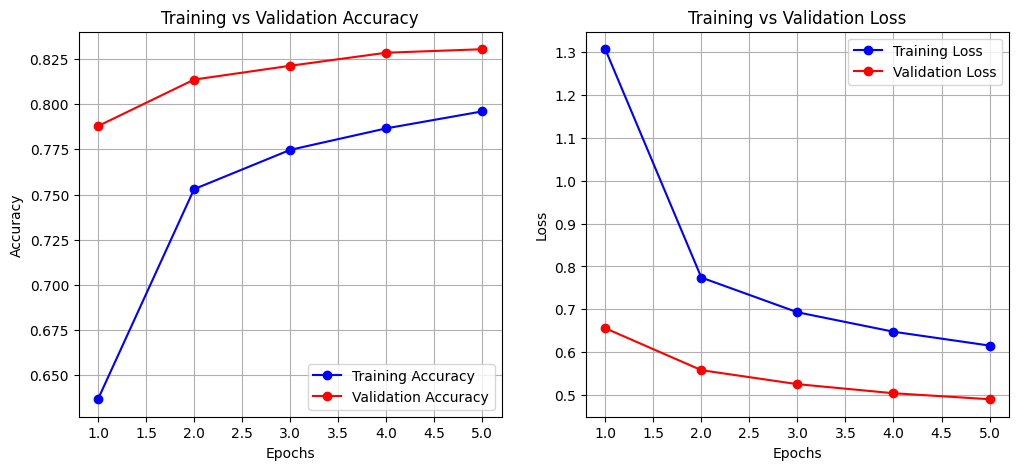

In [7]:
# -----------------------------------------------------------
# 7️⃣ Plot Training and Validation Graphs
# -----------------------------------------------------------
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# ---------------------------
# 📊 Plot Accuracy
# ---------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# ---------------------------
# 📉 Plot Loss
# ---------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


In [19]:
# -----------------------------------------------------------
# 8. Class Mapping Function
# -----------------------------------------------------------
def label_to_char(label):
    """Convert EMNIST class index to corresponding digit or letter."""
    if 0 <= label <= 9:
        return str(label)                # 0–9 → digits
    elif 10 <= label <= 35:
        return chr(label - 10 + ord('A'))  # 10–35 → A–Z
    elif 36 <= label <= 61:
        return chr(label - 36 + ord('a'))  # 36–61 → a–z
    else:
        return "?"

# Display mapping table for reference
print("\n📘 Class Label Mapping:")
print("Range\tMeaning")
print("0–9\tDigits 0–9")
print("10–35\tUppercase A–Z")
print("36–61\tLowercase a–z")



📘 Class Label Mapping:
Range	Meaning
0–9	Digits 0–9
10–35	Uppercase A–Z
36–61	Lowercase a–z


###Testing the Prediction Accuracy


In [22]:
# -----------------------------------------------------------
# 7️⃣ Load and Predict Custom Image
# -----------------------------------------------------------
from google.colab import files
uploaded = files.upload()  # Upload your image (e.g. ima_A.png or ima_9.png)

# Load uploaded image
img = Image.open(io.BytesIO(uploaded[list(uploaded.keys())[0]]))
img = img.resize((28, 28)).convert('L')

# Preprocess
img_array = np.array(img)
img_array = 255 - img_array   # invert colors
img_array = img_array / 255.0
input_data = img_array.reshape(-1, 28, 28, 1)

# Predict
pred = model.predict(input_data)
predicted_class = np.argmax(pred)
predicted_char = label_to_char(predicted_class)

print(f"\n🧠 Predicted class index: {predicted_class}")
print(f"🔤 Predicted character: {predicted_char}")

Saving ima_z.png to ima_z.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

🧠 Predicted class index: 35
🔤 Predicted character: Z


In [24]:
# ✅ Save the trained model as a .pkl file
import pickle

with open("cnn_emnist_digits_alphabets.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Model saved as .pkl files!")

✅ Model saved as .pkl files!


In [25]:
# -----------------------------------------------------------
#  Load Model from PKL
# -----------------------------------------------------------
with open("cnn_emnist_digits_alphabets.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print("✅ Model loaded from cnn_emnist_digits_alphabets.pkl successfully!")

✅ Model loaded from cnn_emnist_digits_alphabets.pkl successfully!
